In [1]:
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import IPython.display as ipd
import pandas as pd
from carat import annotations, audio, display, microtiming, util
import onsetsync
%matplotlib inline

### File Paths

In [2]:
meter_path = 'example_data/djembedancedata/BKO_E1_D1_02_Maraka_C_Marker in sec.csv'
D1_path = 'example_data/djembedancedata/BKO_E1_D1_02_Maraka_P-Dun_vamp_bbc-vamp-plugins_bbc-rhythm_onset.csv'
J1_path = 'example_data/djembedancedata/BKO_E1_D1_02_Maraka_P-Jem-1_vamp_bbc-vamp-plugins_bbc-rhythm_onset.csv'
J2_path = 'example_data/djembedancedata/BKO_E1_D1_02_Maraka_P-Jem-2_vamp_bbc-vamp-plugins_bbc-rhythm_onset.csv'

### Load Onset annotations

In [3]:
df = onsetsync.get_df_csv([D1_path, J1_path, J2_path], delimiter=';', concat_axis=1, header=None)

# Add header to the dataframe
df.columns = ['D1', 'J1', 'J2']
df.head(10)

,D1,J1,J2
0,8.551000,5.881667,10.951000
1,10.073667,6.143000,11.161667
2,10.484333,6.335000,11.569667
3,10.889667,6.428333,11.785667
4,11.127000,6.543000,12.207000
5,11.583000,6.633667,12.420333
6,12.009667,6.793667,12.844333
7,12.668333,7.012333,13.068333
8,13.068333,7.220333,13.497667
9,13.481667,7.452333,13.735000


### Load Meter annotations

In [4]:
meter_df = onsetsync.get_df_csv(meter_path, delimiter=';')
meter_df.columns = ['Keyboard.Time']
meter_df.head()

,Keyboard.Time
0,11.129
1,13.706
2,16.260
3,18.728
4,21.223


#### Visualise Onsets and Cycle Starts

In [5]:
def plot_cycles(df, meter_df, cycle_column, time_lower, time_upper):    
    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 6))

    # Plot each instrument column as subplots
    for i, column in enumerate(df.columns):
        for value in df[column]:
            axes[i].axvline(x=value, ymin=0, ymax=1, color='b', linewidth=0.5)
        
        # Overlay cycle start annotations
        for meter in meter_df[cycle_column]:
            axes[i].axvline(x=meter, ymin=0, ymax=1, color='black', linestyle='dotted')

        # Time range 10s to 20s
        axes[i].set_xlim(time_lower, time_upper) 
        axes[i].set_ylim(0, 1)  # Limit y-axis from 0 to 1 for visualization
        axes[i].set_ylabel(column)

    # Set shared x-axis label
    axes[-1].set_xlabel('Time (s)')

    # Show the plot
    plt.tight_layout()
    plt.show()

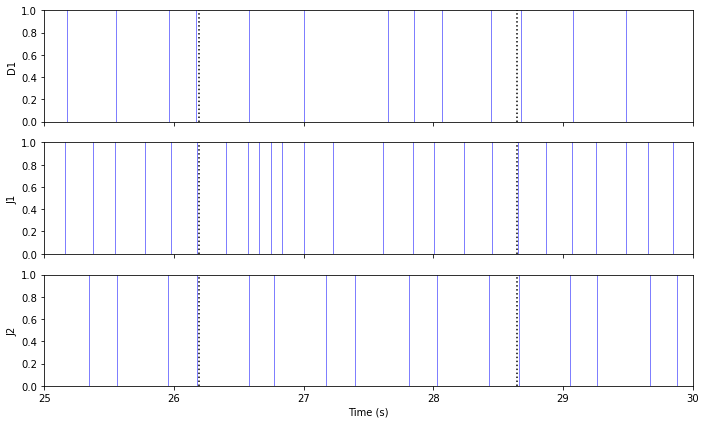

In [6]:
plot_cycles(df, meter_df, 'Keyboard.Time', time_lower=25, time_upper=30)

## Detrending

#### Function Definitions

In [7]:
def add_window(df, cycle_column, window_shape, num_div):
    
    df = df.copy()
    # Window of tolerance for left and right of the cycle annotation
    tol_L = (1/num_div) * window_shape[0]
    tol_R = (1/num_div) * window_shape[1]

    # Calculate cycle lengths on either side of keyboard times
    df['diffL'] = df[cycle_column].diff()  # iloc(n) - iloc(n-1)
    df['diffR'] = df['diffL'].shift(-1)  # iloc(n+1) - iloc(n)

    # Handle the NaN values by filling with the nearest available value
    df['diffL'].fillna(df['diffR'], inplace=True)  # First entry: copy the next value from diffR
    df['diffR'].fillna(df['diffL'], inplace=True)  # Last entry: copy the previous value from diffL

    # Create window on the left and right side of the keyboard time
    df['window_L'] = df['Keyboard.Time'] - (df['diffL'] * tol_L)
    df['window_R'] = df['Keyboard.Time'] + (df['diffR'] * tol_R)

    df.drop(columns=['diffL', 'diffR'], inplace=True)

    return df


def find_closest_onset(time, df):
    """
    Finds the closest value to `time` in the entire DataFrame `df`.
    Ignores NaN values.
    """
    values = df.values.flatten()  # Flatten the DataFrame to a 1D array
    values = values[~np.isnan(values)]  # Remove NaN values
    closest_value = values[(abs(values - time)).argmin()]  # Find the closest value to `time`
    return closest_value


def find_onsets_in_window(window_L, window_R, df):
    valid_onsets_list = []
    
    for column in df.columns:
        valid_onsets = df[column].dropna().loc[(df[column] >= window_L) & (df[column] <= window_R)].values
        
        if valid_onsets.size > 0:
            valid_onsets_list.append(valid_onsets)
        else:
            valid_onsets_list.append(np.array([]))
    
    return valid_onsets_list

### Mode 2 : Intermediate "instrument anchor" (level 2 m.cycle) 

['downbeats to onsets' eq.]
1. Closest instrument (mixed) [choose closest onset to lev1, either instr1 or
instr2]
2. defined.instr.rules [take window, show preference for defined.instr, e.g.
If there is an instr1 stroke in the window select it, else go for the instr2]


In [8]:
# Main function to add Anchor.Time columns to meter_df based on mode
def detrend_anchor(meter_df, time_column, instr_df, window_shape=(0.5,0.5), num_div=None, mode=1):
    """
    Adds level 2 m.cycle times to `meter_df` based on Intermediate "instrument anchor" method.
    
    Parameters:
    - meter_df: DataFrame containing the 'Keyboard.Time' column.
    - instr_df: DataFrame containing the onset times of instruments. The order of columns assumes order of preference.
    - window_shape: Parameter for defining the shape of the window (used in mode=2).
    - num_div: Parameter for dividing the window (used in mode=2).
    - mode: Determines which method to use.
      - mode=1: Uses `Closest Instrument.
      - mode=2: Uses `defined.instr.rules`.
    
    Returns:
    - meter_df with the new 'Anchor.Time.1' or 'Anchor.Time.2' column added.
    """
    
    meter_df = meter_df.copy()
    
    if mode == 1:
        # Add Anchor.Time.1 based on the closest onset among all instruments
        meter_df['Anchor.Time.1'] = meter_df[time_column].apply(lambda time: find_closest_onset(time, instr_df))

    elif mode == 2:
        
        meter_df = add_window(meter_df, time_column, window_shape, num_div)

        for index, row in meter_df.iterrows():
            time = row[time_column]
            win_L = row['window_L']
            win_R = row['window_R']

            # Find the closest onset within the window
            valid_onsets = find_onsets_in_window(win_L, win_R, instr_df)

            closest_onset = time  # Default to original time if no valid onsets are found
            
            # Iterate over all valid onsets collected from different columns
            for onset_array in valid_onsets:
                if onset_array.size > 0:
                    # Compute the absolute differences between 'time' and each valid onset
                    differences = np.abs(onset_array - time)
                    # Find the onset with the minimum difference
                    closest_onset = onset_array[np.argmin(differences)]
                    break  # Exit after finding the closest onset in the first non-empty array

            meter_df.at[index, 'Anchor.Time.2'] = closest_onset
        
        # Drop the window columns after the operation
        meter_df.drop(columns=['window_L', 'window_R'], inplace=True)
        
    else:
        raise ValueError("Invalid mode! Use mode=1 or mode=2")

    return meter_df

#### Select subdivisions, window shape

In [9]:
num_div = 12
window_shape = (0.5, 0.5)

#### Mode 2.1 : Instrument Anchor - Closest Instrument

In [10]:
# ['D1', 'J1', 'J2']
defined_instr = ['J1'] 

In [12]:
meter_df = detrend_anchor(meter_df, 
                           time_column='Keyboard.Time', 
                           instr_df=df[defined_instr], 
                           window_shape=window_shape, 
                           num_div=num_div, 
                           mode=1)

In [13]:
meter_df.head()

,Keyboard.Time,Anchor.Time.1
0,11.129,11.108333
1,13.706,13.497667
2,16.260,16.249667
3,18.728,18.729667
4,21.223,21.025667


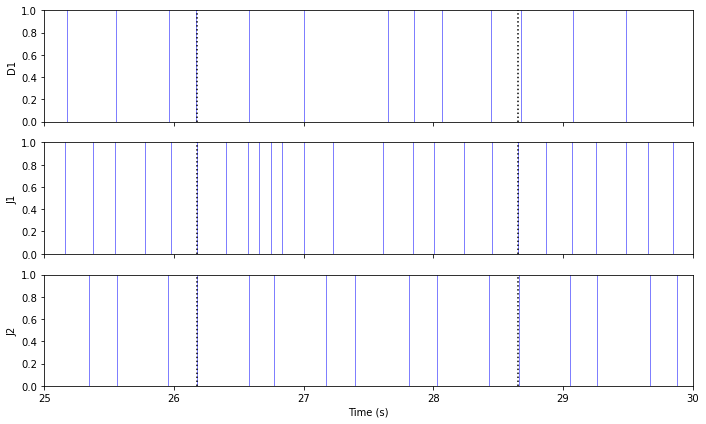

In [14]:
plot_cycles(df, meter_df, 'Anchor.Time.1', time_lower=25, time_upper=30)

### Mode 2.2 : Instrument Anchor - defined.instr.rules

For this sub-mode, order of preference is assumed in the list. For example in the list below D1 > J1 > J2

In [15]:
defined_instr = ['D1', 'J1', 'J2']

In [16]:
meter_df = detrend_anchor(meter_df, 
                           time_column='Keyboard.Time', 
                           instr_df=df[defined_instr], 
                           window_shape=window_shape, 
                           num_div=num_div, 
                           mode=2)

In [17]:
meter_df.head()

,Keyboard.Time,Anchor.Time.1,Anchor.Time.2
0,11.129,11.108333,11.127000
1,13.706,13.497667,13.700333
2,16.260,16.249667,16.263000
3,18.728,18.729667,18.732333
4,21.223,21.025667,21.223000


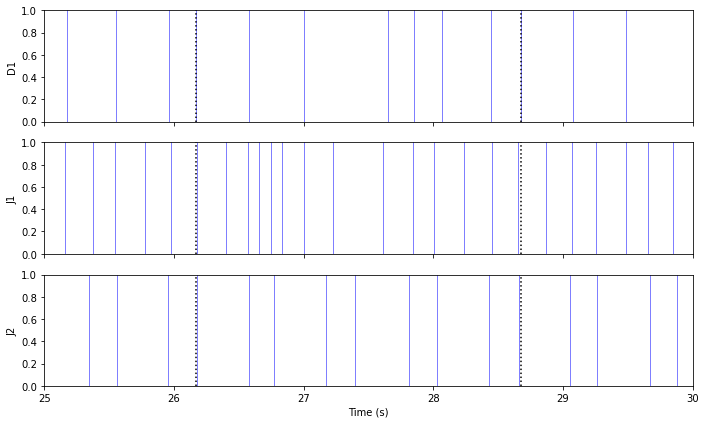

In [18]:
plot_cycles(df, meter_df, 'Anchor.Time.2', time_lower=25, time_upper=30)

### Create new DF by interpolating Cycles into 12 subdivisions

In [20]:
# Create interpolated points
cycle_times = meter_df['Keyboard.Time'].to_numpy()

interp_time = [np.linspace(cycle_times[i], cycle_times[i + 1], num_div+1)[:-1] for i in range(len(cycle_times) - 1)]
interp_time = np.concatenate(interp_time)
interp_time = np.append(interp_time, cycle_times[-1])

# Create cycle numbers
cycle_numbers = np.repeat(np.arange(1, len(cycle_times)), num_div)
cycle_numbers = np.append(cycle_numbers, len(cycle_times))

# Create a dataframe
new_df = pd.DataFrame({
    'Cycle': cycle_numbers,
    'Subdivision': np.append(np.tile(np.arange(1, num_div+1), len(cycle_times) - 1), 1),
    'Iso.Time': interp_time       
})

# Insert original cycle times at subdivision 1 positions
new_df['Cycle.Time'] = np.nan  # Initialize the column with NaN
new_df.loc[new_df['Subdivision'] == 1, 'Cycle.Time'] = cycle_times

# Re-arrange columns
new_df = new_df[['Cycle','Cycle.Time','Subdivision','Iso.Time']]

# Add instrument columns
new_df[['D1', 'J1', 'J2']] = np.nan

In [21]:
new_df.tail(13)

,Cycle,Cycle.Time,Subdivision,Iso.Time,D1,J1,J2
2472,207,335.231,1,335.23100,NaN,NaN,NaN
2473,207,NaN,2,335.34325,NaN,NaN,NaN
2474,207,NaN,3,335.45550,NaN,NaN,NaN
2475,207,NaN,4,335.56775,NaN,NaN,NaN
2476,207,NaN,5,335.68000,NaN,NaN,NaN
2477,207,NaN,6,335.79225,NaN,NaN,NaN
2478,207,NaN,7,335.90450,NaN,NaN,NaN
2479,207,NaN,8,336.01675,NaN,NaN,NaN
2480,207,NaN,9,336.12900,NaN,NaN,NaN
2481,207,NaN,10,336.24125,NaN,NaN,NaN
